In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
# sys.path.append('E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/models/unet')

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

from utils import (
    save_checkpoint,
    load_checkpoint,
    get_loaders,
    check_accuracy,
    save_predictions_as_imgs,
    summarize_eco2ai_log,
    )

from model import UNET

from eco2ai import Tracker

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNET(in_channel=1, out_channel=1).to(device)
summary(model, input_size=(1, 256, 256), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 256, 256]             576
       BatchNorm2d-2         [32, 64, 256, 256]             128
              ReLU-3         [32, 64, 256, 256]               0
            Conv2d-4         [32, 64, 256, 256]          36,864
       BatchNorm2d-5         [32, 64, 256, 256]             128
              ReLU-6         [32, 64, 256, 256]               0
        DoubleConv-7         [32, 64, 256, 256]               0
         MaxPool2d-8         [32, 64, 128, 128]               0
            Conv2d-9        [32, 128, 128, 128]          73,728
      BatchNorm2d-10        [32, 128, 128, 128]             256
             ReLU-11        [32, 128, 128, 128]               0
           Conv2d-12        [32, 128, 128, 128]         147,456
      BatchNorm2d-13        [32, 128, 128, 128]             256
             ReLU-14        [32, 128, 1

In [5]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation.zip"
extract_path = "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted"

# Extract ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List extracted files
os.listdir(extract_path)

['Modified_3_Brain_Tumor_Segmentation']

In [6]:
IMG_DIR      =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/images"
MASK_DIR     =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/masks"
VAL_IMG_DIR  =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/val_images"
VAL_MASK_DIR =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/val_masks"

In [7]:
Device = "cuda" if torch.cuda.is_available() else "cpu"
Learning_rate = 1e-3 # 1e-4 originally
Batch_size  = 32
num_epochs  = 60
num_workers = 4
IMAGE_HEIGHT = 256 # 512 originally
IMAGE_WIDTH  = 256 # 512 originally
PIN_MEMORY = True
LOAD_MODEL = False
CHECKPOINT_NAME = None

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    tracker = Tracker(
        project_name="U_Net_Training_Project",
        experiment_description="Training U_Net Model",
        output_file="U_Net_eco2ai_logs.csv",
        country_iso_code="EG",  
        track_cpu=False
    )
    tracker.start()

    loop = tqdm(loader)
    running_loss=0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=Device)
        targets = targets.float().unsqueeze(1).to(device=Device)

        with torch.amp.autocast(device_type=Device):
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        running_loss+=loss.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())

    tracker.stop()

    return running_loss/len(loader)

In [ ]:
def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    model = UNET(in_channel=1, out_channel=1).to(Device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=Learning_rate)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    # scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    train_loader, val_loader = get_loaders(
        IMG_DIR,
        MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        Batch_size,
        train_transform,
        val_transform,
        num_workers,
        PIN_MEMORY,
    )

    train_losses=[]
    val_dice_scores=[]
    val_accs=[]

    if LOAD_MODEL:
        load_checkpoint(model=model, optimizer=optimizer, checkpoint_name=CHECKPOINT_NAME)
        check_accuracy(val_loader, model, device=Device)

    scaler = torch.amp.GradScaler()

    for epoch in range(num_epochs):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 82/82 [05:10<00:00,  3.79s/it, loss=0.17]


Got 28818978/29360128 with acc  98.16
Dice score: 0.0
Epoch 0: LR = 0.001
✅ Checkpoint saved: U_Net_checkpoint_1_2025-04-20_04-29-39.pth.tar


100%|██████████| 82/82 [01:06<00:00,  1.24it/s, loss=0.0853]


Got 28849158/29360128 with acc  98.26
Dice score: 0.20850525796413422
Epoch 1: LR = 0.001
✅ Checkpoint saved: U_Net_checkpoint_2_2025-04-20_04-31-16.pth.tar


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0637]


Got 28205363/29360128 with acc  96.07
Dice score: 0.3294892907142639
Epoch 2: LR = 0.001
✅ Checkpoint saved: U_Net_checkpoint_3_2025-04-20_04-32-55.pth.tar


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0488]


Got 28616818/29360128 with acc  97.47
Dice score: 0.4867023825645447
Epoch 3: LR = 0.001
✅ Checkpoint saved: U_Net_checkpoint_4_2025-04-20_04-34-34.pth.tar


100%|██████████| 82/82 [01:06<00:00,  1.23it/s, loss=0.0323]


Got 28939173/29360128 with acc  98.57
Dice score: 0.4272259473800659
Epoch 4: LR = 0.001


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0378]


Got 28955383/29360128 with acc  98.62
Dice score: 0.5346512794494629
Epoch 5: LR = 0.001
✅ Checkpoint saved: U_Net_checkpoint_5_2025-04-20_04-37-49.pth.tar


100%|██████████| 82/82 [01:06<00:00,  1.23it/s, loss=0.0454]


Got 28978031/29360128 with acc  98.70
Dice score: 0.6193403601646423
Epoch 6: LR = 0.0005
✅ Checkpoint saved: U_Net_checkpoint_6_2025-04-20_04-39-28.pth.tar


100%|██████████| 82/82 [01:06<00:00,  1.23it/s, loss=0.0331]


Got 29009310/29360128 with acc  98.81
Dice score: 0.5974841117858887
Epoch 7: LR = 0.0005


100%|██████████| 82/82 [01:06<00:00,  1.23it/s, loss=0.0233]


Got 29023172/29360128 with acc  98.85
Dice score: 0.633980393409729
Epoch 8: LR = 0.0005
✅ Checkpoint saved: U_Net_checkpoint_7_2025-04-20_04-42-42.pth.tar


100%|██████████| 82/82 [01:06<00:00,  1.23it/s, loss=0.0342]


Got 29015777/29360128 with acc  98.83
Dice score: 0.6461045742034912
Epoch 9: LR = 0.0005
✅ Checkpoint saved: U_Net_checkpoint_8_2025-04-20_04-44-20.pth.tar


100%|██████████| 82/82 [01:06<00:00,  1.23it/s, loss=0.0375]


Got 29002664/29360128 with acc  98.78
Dice score: 0.5550592541694641
Epoch 10: LR = 0.0005


100%|██████████| 82/82 [01:06<00:00,  1.23it/s, loss=0.0272]


Got 28964291/29360128 with acc  98.65
Dice score: 0.67340487241745
Epoch 11: LR = 0.0005
✅ Checkpoint saved: U_Net_checkpoint_9_2025-04-20_04-47-34.pth.tar


100%|██████████| 82/82 [01:06<00:00,  1.23it/s, loss=0.0435]


Got 29021091/29360128 with acc  98.85
Dice score: 0.6762999296188354
Epoch 12: LR = 0.00025
✅ Checkpoint saved: U_Net_checkpoint_10_2025-04-20_04-49-10.pth.tar


100%|██████████| 82/82 [01:06<00:00,  1.23it/s, loss=0.0184]


Got 29056836/29360128 with acc  98.97
Dice score: 0.6803274750709534
Epoch 13: LR = 0.00025
✅ Checkpoint saved: U_Net_checkpoint_11_2025-04-20_04-50-47.pth.tar


100%|██████████| 82/82 [01:06<00:00,  1.23it/s, loss=0.0232]


Got 29031693/29360128 with acc  98.88
Dice score: 0.6664949655532837
Epoch 14: LR = 0.00025


100%|██████████| 82/82 [01:06<00:00,  1.23it/s, loss=0.0289]


Got 29038798/29360128 with acc  98.91
Dice score: 0.7029666304588318
Epoch 15: LR = 0.00025
✅ Checkpoint saved: U_Net_checkpoint_12_2025-04-20_04-53-58.pth.tar


100%|██████████| 82/82 [01:06<00:00,  1.23it/s, loss=0.0273]


Got 29077980/29360128 with acc  99.04
Dice score: 0.7253970503807068
Epoch 16: LR = 0.00025
✅ Checkpoint saved: U_Net_checkpoint_13_2025-04-20_04-55-35.pth.tar


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0177]


Got 29055379/29360128 with acc  98.96
Dice score: 0.6850758790969849
Epoch 17: LR = 0.00025


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0256]


Got 29042815/29360128 with acc  98.92
Dice score: 0.7000505924224854
Epoch 18: LR = 0.000125


100%|██████████| 82/82 [01:06<00:00,  1.23it/s, loss=0.0181]


Got 29088117/29360128 with acc  99.07
Dice score: 0.7239950299263
Epoch 19: LR = 0.000125


100%|██████████| 82/82 [01:06<00:00,  1.23it/s, loss=0.0176]


Got 29082464/29360128 with acc  99.05
Dice score: 0.728381872177124
Epoch 20: LR = 0.000125
✅ Checkpoint saved: U_Net_checkpoint_14_2025-04-20_05-01-59.pth.tar


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0134]


Got 29097809/29360128 with acc  99.11
Dice score: 0.7428588271141052
Epoch 21: LR = 0.000125
✅ Checkpoint saved: U_Net_checkpoint_15_2025-04-20_05-03-36.pth.tar


100%|██████████| 82/82 [01:07<00:00,  1.21it/s, loss=0.0162]


Got 29095545/29360128 with acc  99.10
Dice score: 0.733836829662323
Epoch 22: LR = 0.000125


100%|██████████| 82/82 [01:07<00:00,  1.21it/s, loss=0.0159]


Got 29078141/29360128 with acc  99.04
Dice score: 0.6906592845916748
Epoch 23: LR = 0.000125


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0139]


Got 29098902/29360128 with acc  99.11
Dice score: 0.7446860074996948
Epoch 24: LR = 6.25e-05
✅ Checkpoint saved: U_Net_checkpoint_16_2025-04-20_05-08-26.pth.tar


100%|██████████| 82/82 [01:08<00:00,  1.21it/s, loss=0.0189]


Got 29100985/29360128 with acc  99.12
Dice score: 0.7403772473335266
Epoch 25: LR = 6.25e-05


100%|██████████| 82/82 [01:07<00:00,  1.21it/s, loss=0.013]


Got 29117509/29360128 with acc  99.17
Dice score: 0.7643669247627258
Epoch 26: LR = 6.25e-05
✅ Checkpoint saved: U_Net_checkpoint_17_2025-04-20_05-11-40.pth.tar


100%|██████████| 82/82 [01:08<00:00,  1.20it/s, loss=0.0212]


Got 29111239/29360128 with acc  99.15
Dice score: 0.7613708972930908
Epoch 27: LR = 6.25e-05


100%|██████████| 82/82 [01:08<00:00,  1.20it/s, loss=0.0189]


Got 29117804/29360128 with acc  99.17
Dice score: 0.7707838416099548
Epoch 28: LR = 6.25e-05
✅ Checkpoint saved: U_Net_checkpoint_18_2025-04-20_05-14-56.pth.tar


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0131]


Got 29104763/29360128 with acc  99.13
Dice score: 0.7509124279022217
Epoch 29: LR = 6.25e-05


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0189]


Got 29105585/29360128 with acc  99.13
Dice score: 0.7633616328239441
Epoch 30: LR = 3.125e-05


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0144]


Got 29112462/29360128 with acc  99.16
Dice score: 0.7702375054359436
Epoch 31: LR = 3.125e-05


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0133]


Got 29118854/29360128 with acc  99.18
Dice score: 0.7727243304252625
Epoch 32: LR = 3.125e-05
✅ Checkpoint saved: U_Net_checkpoint_19_2025-04-20_05-21-27.pth.tar


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0191]


Got 29119784/29360128 with acc  99.18
Dice score: 0.7725726962089539
Epoch 33: LR = 3.125e-05


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0147]


Got 29114219/29360128 with acc  99.16
Dice score: 0.7614148259162903
Epoch 34: LR = 3.125e-05


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0203]


Got 29114850/29360128 with acc  99.16
Dice score: 0.75527024269104
Epoch 35: LR = 3.125e-05


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0146]


Got 29115282/29360128 with acc  99.17
Dice score: 0.7616866230964661
Epoch 36: LR = 1.5625e-05


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.018]


Got 29114682/29360128 with acc  99.16
Dice score: 0.7722500562667847
Epoch 37: LR = 1.5625e-05


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0128]


Got 29116741/29360128 with acc  99.17
Dice score: 0.7710712552070618
Epoch 38: LR = 1.5625e-05


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0165]


Got 29115407/29360128 with acc  99.17
Dice score: 0.7665431499481201
Epoch 39: LR = 1.5625e-05


100%|██████████| 82/82 [01:07<00:00,  1.21it/s, loss=0.0178]


Got 29119138/29360128 with acc  99.18
Dice score: 0.7681400775909424
Epoch 40: LR = 1.5625e-05


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0219]


Got 29121813/29360128 with acc  99.19
Dice score: 0.7753717303276062
Epoch 41: LR = 1.5625e-05
✅ Checkpoint saved: U_Net_checkpoint_20_2025-04-20_05-35-51.pth.tar


100%|██████████| 82/82 [01:07<00:00,  1.21it/s, loss=0.0134]


Got 29119312/29360128 with acc  99.18
Dice score: 0.7762415409088135
Epoch 42: LR = 7.8125e-06
✅ Checkpoint saved: U_Net_checkpoint_21_2025-04-20_05-37-29.pth.tar


100%|██████████| 82/82 [01:07<00:00,  1.21it/s, loss=0.0159]


Got 29120857/29360128 with acc  99.19
Dice score: 0.7765852808952332
Epoch 43: LR = 7.8125e-06
✅ Checkpoint saved: U_Net_checkpoint_22_2025-04-20_05-39-07.pth.tar


100%|██████████| 82/82 [01:14<00:00,  1.10it/s, loss=0.0207]


Got 29120780/29360128 with acc  99.18
Dice score: 0.7712991833686829
Epoch 44: LR = 7.8125e-06


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0119]


Got 29121043/29360128 with acc  99.19
Dice score: 0.7752208113670349
Epoch 45: LR = 7.8125e-06


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0173]


Got 29120484/29360128 with acc  99.18
Dice score: 0.7728645205497742
Epoch 46: LR = 7.8125e-06


100%|██████████| 82/82 [01:07<00:00,  1.22it/s, loss=0.0132]


Got 29119282/29360128 with acc  99.18
Dice score: 0.7792627215385437
Epoch 47: LR = 7.8125e-06
✅ Checkpoint saved: U_Net_checkpoint_23_2025-04-20_05-45-40.pth.tar


100%|██████████| 82/82 [01:07<00:00,  1.21it/s, loss=0.0121]


Got 29120194/29360128 with acc  99.18
Dice score: 0.7751470804214478
Epoch 48: LR = 3.90625e-06


100%|██████████| 82/82 [01:08<00:00,  1.20it/s, loss=0.0138]


Got 29121061/29360128 with acc  99.19
Dice score: 0.7734816670417786
Epoch 49: LR = 3.90625e-06


100%|██████████| 82/82 [01:08<00:00,  1.20it/s, loss=0.012]


Got 29120257/29360128 with acc  99.18
Dice score: 0.7736806273460388
Epoch 50: LR = 3.90625e-06


100%|██████████| 82/82 [01:08<00:00,  1.20it/s, loss=0.0123]


Got 29119128/29360128 with acc  99.18
Dice score: 0.770285427570343
Epoch 51: LR = 3.90625e-06


100%|██████████| 82/82 [01:08<00:00,  1.20it/s, loss=0.0136]


Got 29120856/29360128 with acc  99.19
Dice score: 0.7779436707496643
Epoch 52: LR = 3.90625e-06


100%|██████████| 82/82 [01:08<00:00,  1.20it/s, loss=0.0106]


Got 29120376/29360128 with acc  99.18
Dice score: 0.7779237031936646
Epoch 53: LR = 3.90625e-06


100%|██████████| 82/82 [01:08<00:00,  1.20it/s, loss=0.0154]


Got 29119863/29360128 with acc  99.18
Dice score: 0.7751916646957397
Epoch 54: LR = 1.953125e-06


100%|██████████| 82/82 [01:08<00:00,  1.20it/s, loss=0.0147]


Got 29119504/29360128 with acc  99.18
Dice score: 0.7730514407157898
Epoch 55: LR = 1.953125e-06


100%|██████████| 82/82 [01:08<00:00,  1.20it/s, loss=0.0191]


Got 29120397/29360128 with acc  99.18
Dice score: 0.7754091024398804
Epoch 56: LR = 1.953125e-06


100%|██████████| 82/82 [01:08<00:00,  1.20it/s, loss=0.00913]


Got 29120297/29360128 with acc  99.18
Dice score: 0.7720364928245544
Epoch 57: LR = 1.953125e-06


100%|██████████| 82/82 [01:08<00:00,  1.20it/s, loss=0.0136]


Got 29120435/29360128 with acc  99.18
Dice score: 0.7757726311683655
Epoch 58: LR = 1.953125e-06


100%|██████████| 82/82 [01:07<00:00,  1.21it/s, loss=0.0222]


Got 29122264/29360128 with acc  99.19
Dice score: 0.775896430015564
Epoch 59: LR = 1.953125e-06


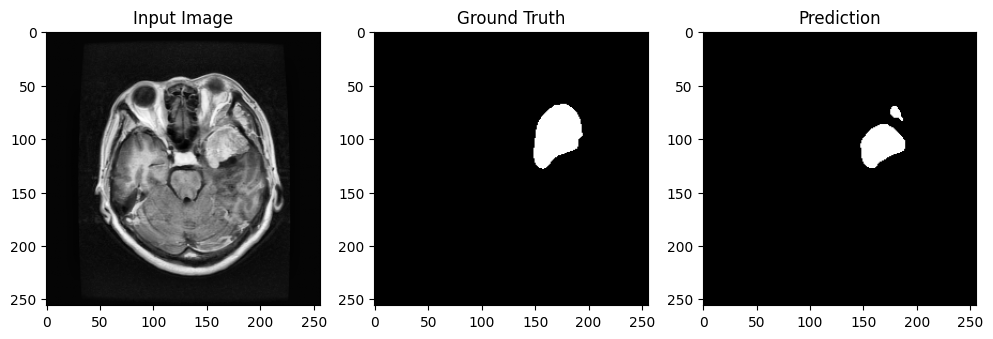

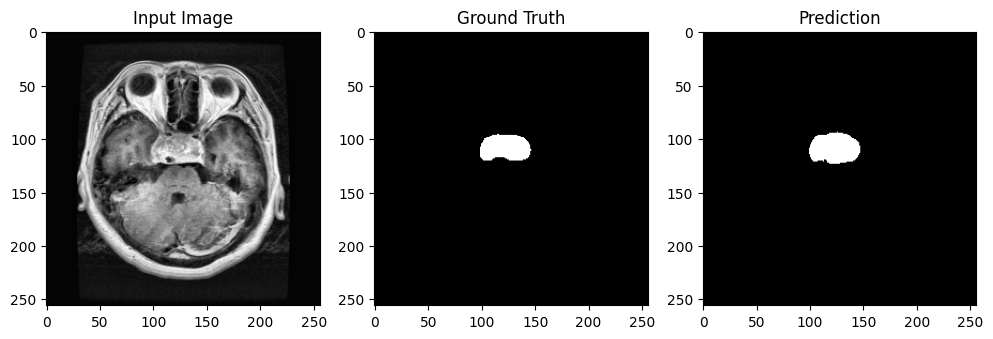

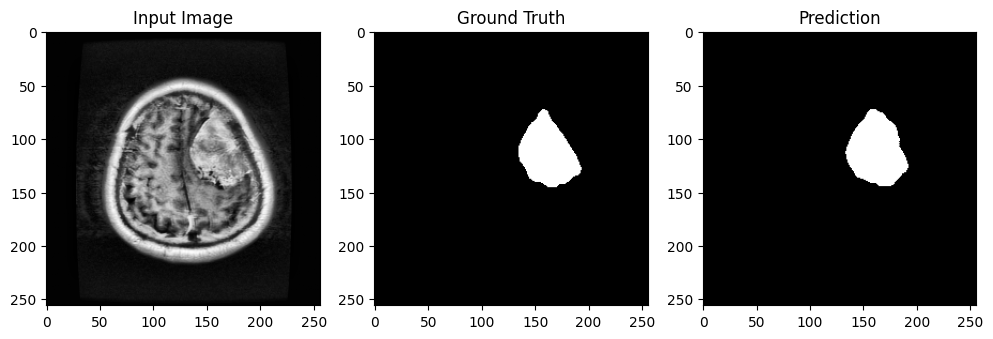

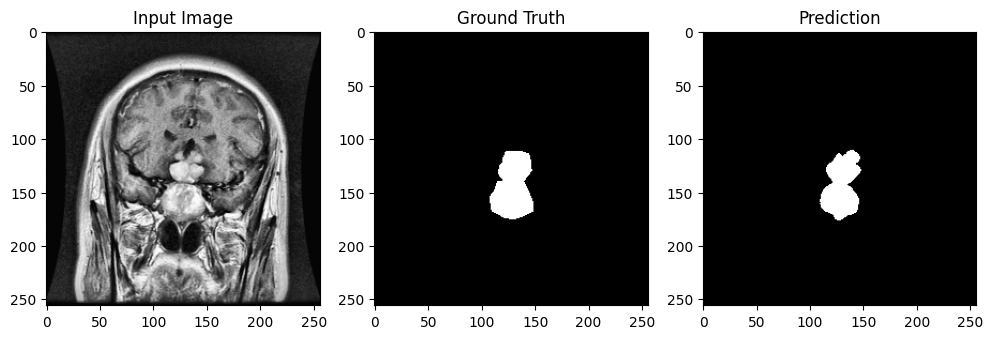

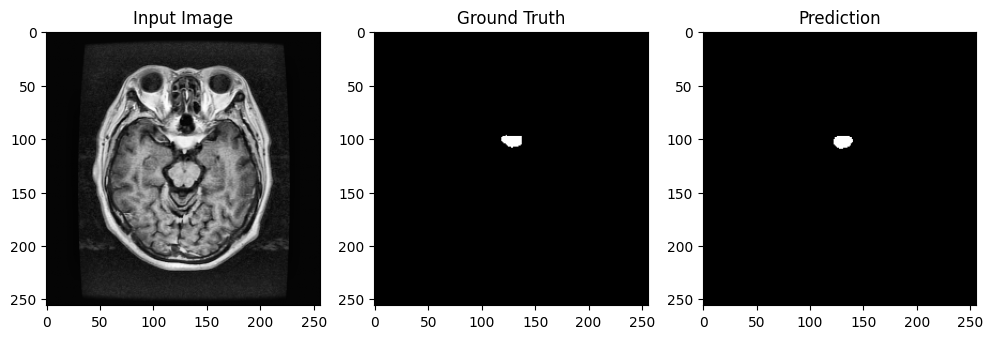

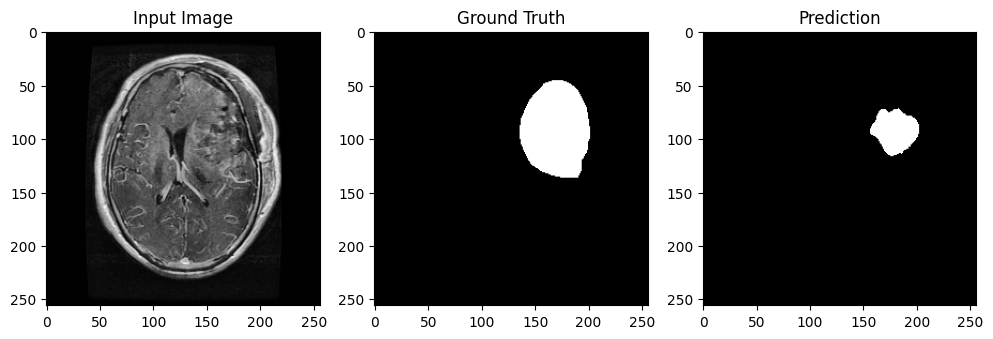

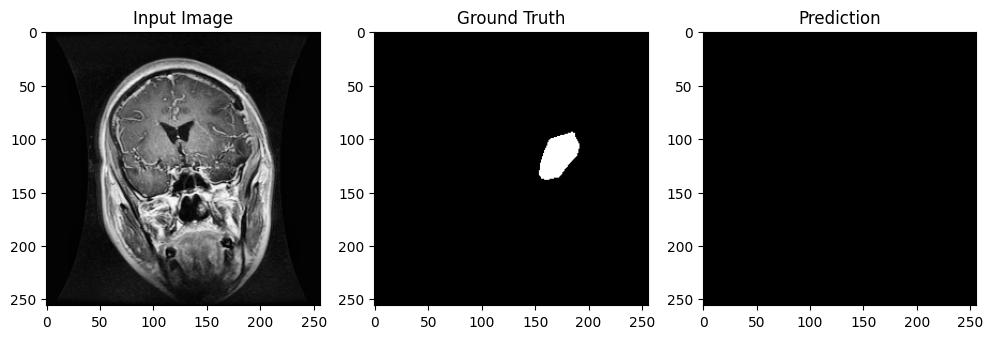

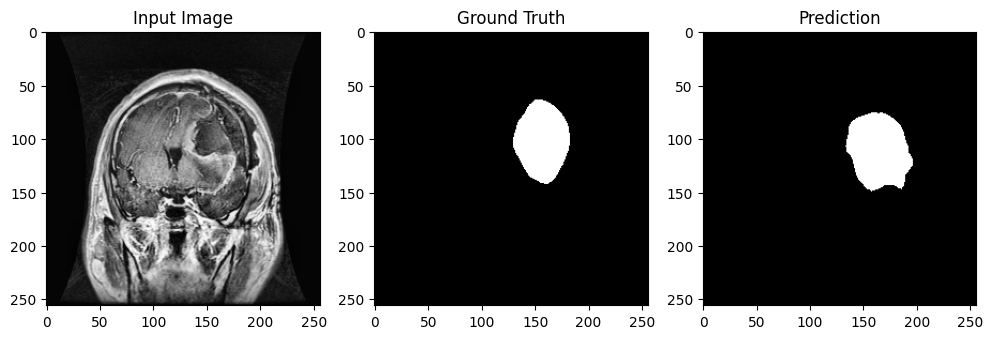

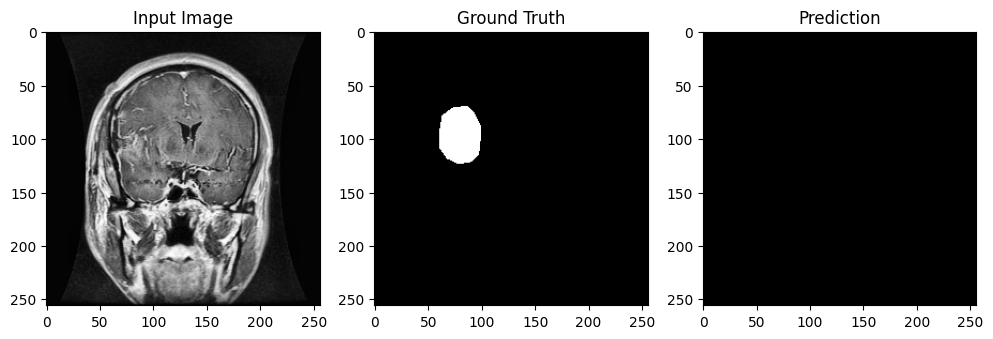

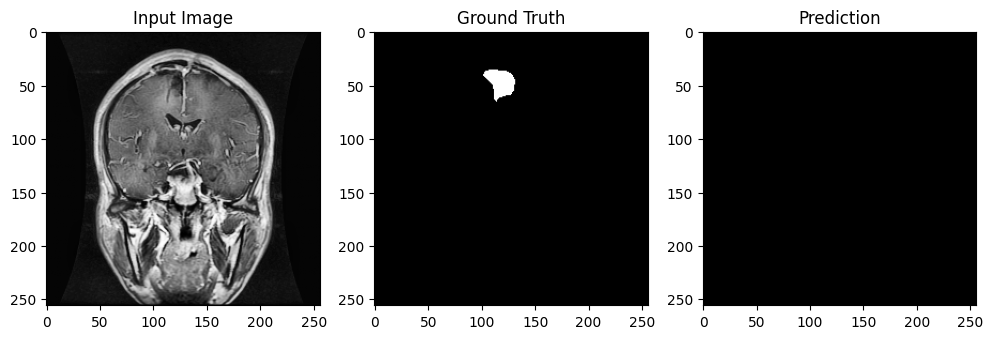

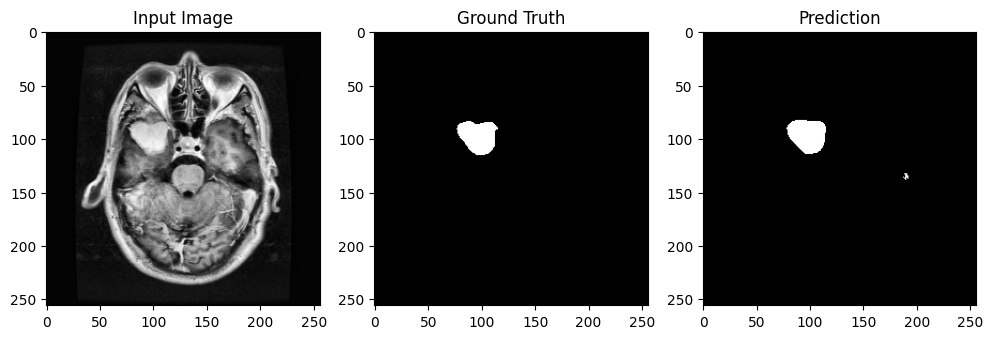

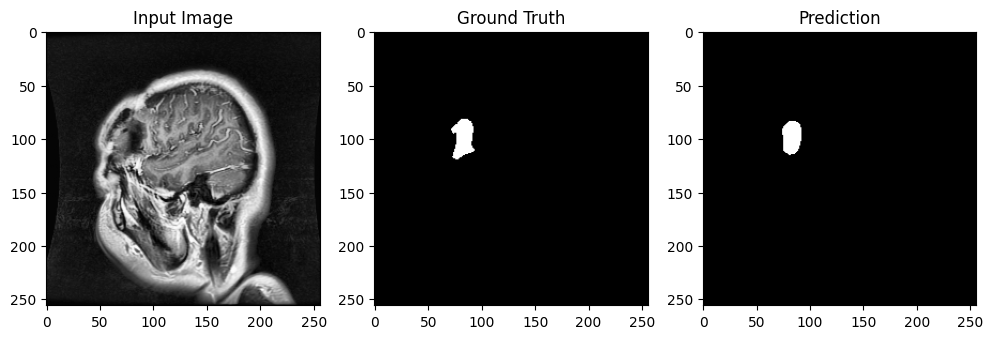

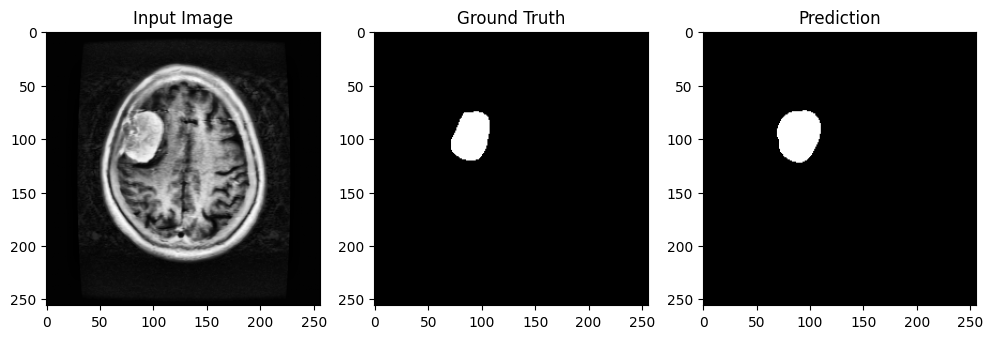

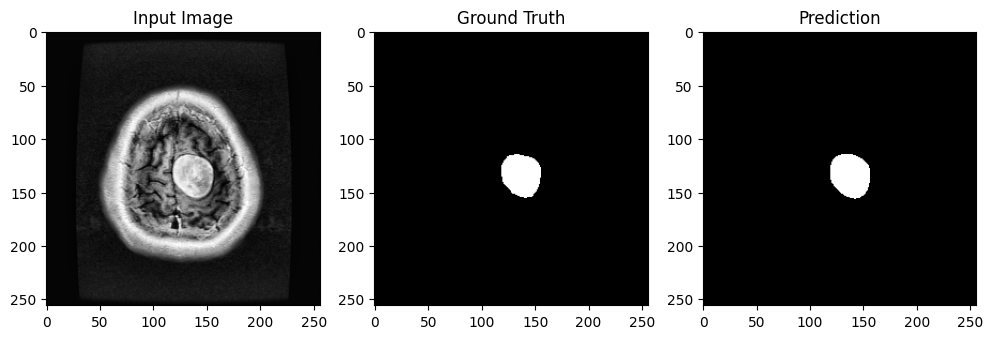

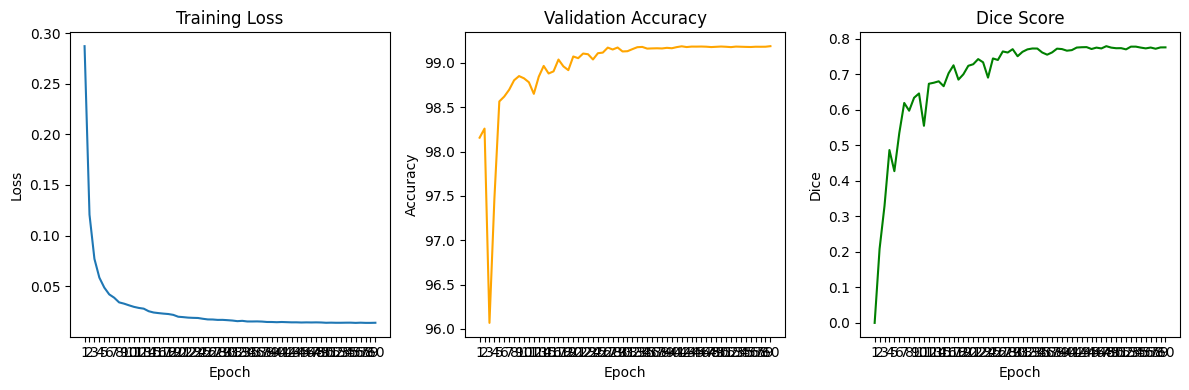

In [10]:
if __name__ == "__main__":
    main()

In [ ]:
summarize_eco2ai_log("U_Net_eco2ai_logs.csv")

In [ ]:
from google.colab import files

# Download the Eco2AI Logs
files.download("U_Net_eco2ai_logs.csv")